In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import poisson, gamma, norm

from sklearn.neighbors import KernelDensity
from scipy.signal import argrelextrema
plt.ion()
plt.show()

np.random.seed(1)

In [81]:
## Generate a compound poisson process, of intensity mu with num_event event. 
def generate_poisson_process(mu, num_events):
    time_intervals = -np.log(np.random.random(num_events)) / mu
    total_events = time_intervals.cumsum()
    events = pd.DataFrame(np.ones(num_events), index=total_events)
    events[0] = events[0].cumsum()
    return events



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


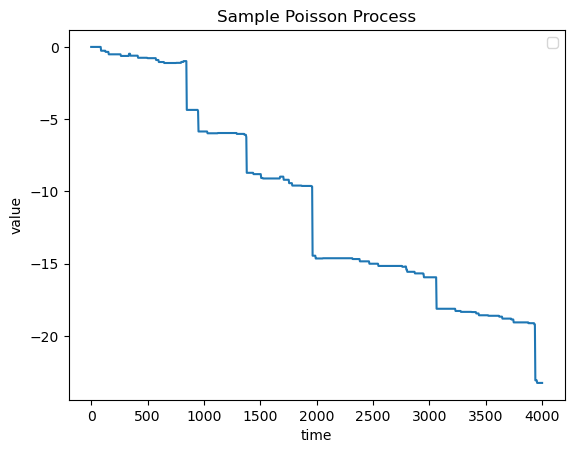

In [82]:
parameters = np.array([[-2, 1],
                        [-0.1,  0.1]])
weights = np.array([0.2, 0.8])

def generate_cpp(mu, timeMAX):
    size_time = 1000 +1
        
    time_space = np.linspace(0, timeMAX, size_time)
    dt = time_space[1]-time_space[0]
    
    number_jump = poisson.rvs(mu * dt, size=size_time-1)
    #print(number_jump)
    process = np.zeros(size_time)
    
    for i in range(size_time-1):
        mixture = np.random.choice(len(weights), size = number_jump[i], replace=True, p = weights)
        aux = np.array([norm.rvs(*(parameters[j])) for j in mixture])
        #aux = np.array([gamma.rvs(3, size=number_jump[i])])
        process[i+1] = process[i] + np.sum(aux)
    #return (time_space, process + norm.rvs(0,0.5, size_time))
    return (time_space, process )
    
time, process = generate_cpp(1/60, 4000)
#plt.plot(time, process, marker='.', linestyle='none')
plt.plot(time, process)
plt.title("Sample Poisson Process")
plt.xlabel("time")
plt.ylabel("value")
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


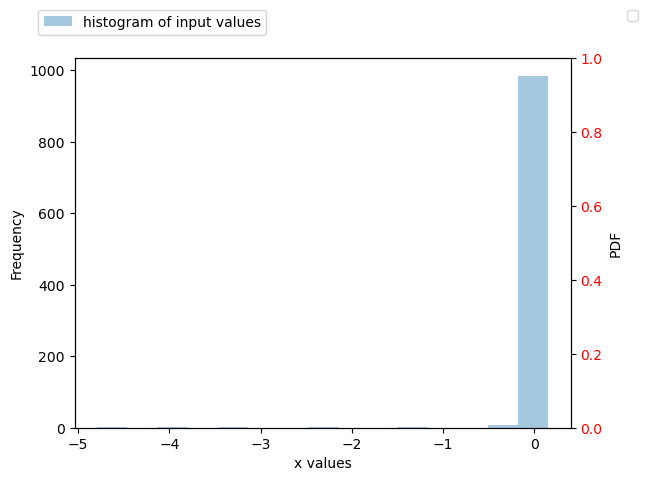

In [83]:
def plotHistogramAndPdf(data):
    x = np.linspace(np.min(data),np.max(data), len(data)-1)
    ax = plt.gca()
    plt.hist(data, bins = 15, alpha = 0.4, label = 'histogram of input values');
    plt.ylabel('Frequency')
    plt.xlabel('x values')
    ax2 = ax.twinx()
    #plt.plot(x, pdf, c = 'red', label = 'probability density function');
    plt.ylabel('PDF')
    [tl.set_color('r') for tl in ax2.get_yticklabels()]
    ax.legend(bbox_to_anchor=(0.4, 1.15))
    ax2.legend(bbox_to_anchor=(1.15,1.15))
    plt.savefig('figures/hist.jpg', bbox_inches='tight')

data = [process[i+1]-process[i] for i in range(len(process)-1)]
x = np.linspace(np.min(data),np.max(data), 1000)

plotHistogramAndPdf(data)

# Kernel density estimations



x:  -4.670583664259424e+00  | y:  0.0010915298077842917
x:  -3.617041549003112  | y:  0.0016859326217578726
x:  -2.291458042483433  | y:  0.0019778188300234455
x:  -0.006310355871151252  | y:  0.9886734122133993
[ 24 237 505 967]


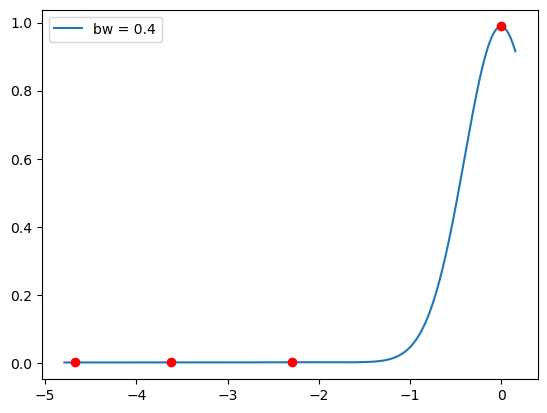

In [84]:
def GaussianKernel(u):
    return np.exp(-0.5*u**2)/(np.sqrt(2*np.pi))
def RosenblattKernel(u):
    if (-1<= u <= 1):
        return 0.5
    else:
        return 0

def KernelEstimator(u, data, h, kernel):
    N = len(data)
    value = 0
    for k in range(N):
        value = value + kernel((u-data[k])/h)
    return value/(N * h)

# for local maxima

for h in [0.4]:
    y = np.array([KernelEstimator(i, data, h, GaussianKernel) for i in x])
    local_max = argrelextrema(y, np.greater)
    plt.plot(x, y, label='bw = '+str(h))
    plt.plot([x[i] for i in local_max], [y[i] for i in local_max], 'ro')
plt.legend(loc='best')

for i in local_max[0]:
    print('x: ', x[i], ' | y: ', y[i]) 
    
print(local_max[0])
    


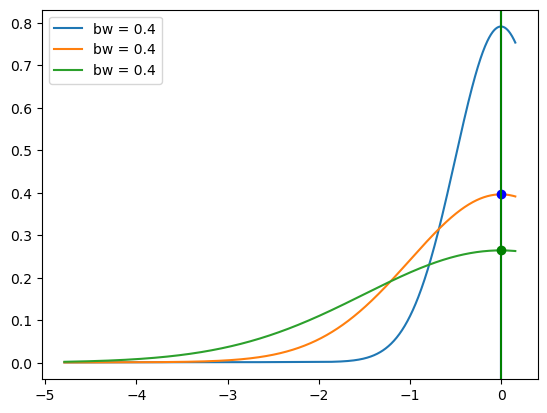

In [85]:

y1 = np.array([KernelEstimator(i, data, 0.5, GaussianKernel) for i in x])
local_max1 = argrelextrema(y1, np.greater)

y2 = np.array([KernelEstimator(i, data, 1, GaussianKernel) for i in x])
local_max2 = argrelextrema(y2, np.greater)

y3 = np.array([KernelEstimator(i, data, 1.5, GaussianKernel) for i in x])
local_max3 = argrelextrema(y3, np.greater)

plt.plot(x, y1, label='bw = '+str(h))
plt.plot(x, y2, label='bw = '+str(h))
plt.plot(x, y3, label='bw = '+str(h))

#plt.plot([x[i] for i in local_max1], [y1[i] for i in local_max1], 'ro')
#for i in local_max1[0]:
#    plt.axvline(x[i], color='red')
plt.plot([x[i] for i in local_max2], [y2[i] for i in local_max2], 'bo')
for i in local_max2[0]:
    plt.axvline(x[i], color='blue')
plt.plot([x[i] for i in local_max3], [y3[i] for i in local_max3], 'go')
for i in local_max3[0]:
    plt.axvline(x[i], color='green')

plt.legend(loc='best')

# Find the critical $h_*$

In [86]:
def critical_value(hmax, num_mode):
    hmin_test=0
    hmax_test=hmax
    for iter in range(15):
        h_test = 0.5*(hmin_test+hmax_test)
        y = np.array([KernelEstimator(i, data, h_test, GaussianKernel) for i in x])
        local_max = argrelextrema(y, np.greater)
        if len(local_max[0])<= num_mode:
            hmax_test = h_test
            print(iter, len(local_max[0]), hmin_test, hmax_test)
        else:
            hmin_test = h_test
            print(iter, len(local_max[0]), hmin_test, hmax_test)
    return hmin_test

hcrit1 = critical_value(10, 1)
hcrit2 = critical_value(10, 2)
hcrit3 = critical_value(10, 3)
hcrit4 = critical_value(10, 4)

hcritALL = [hcrit1, hcrit2, hcrit3, hcrit4]
print(hcritALL)

0 1 0 5.0
1 1 0 2.5
2 1 0 1.25
3 1 0 0.625
4 4 0.3125 0.625
5 3 0.46875 0.625
6 2 0.546875 0.625
7 1 0.546875 0.5859375
8 2 0.56640625 0.5859375
9 2 0.576171875 0.5859375
10 2 0.5810546875 0.5859375
11 2 0.58349609375 0.5859375
12 1 0.58349609375 0.584716796875
13 1 0.58349609375 0.5841064453125
14 1 0.58349609375 0.58380126953125
0 1 0 5.0
1 1 0 2.5
2 1 0 1.25
3 1 0 0.625
4 4 0.3125 0.625
5 3 0.46875 0.625
6 2 0.46875 0.546875
7 2 0.46875 0.5078125
8 2 0.46875 0.48828125
9 3 0.478515625 0.48828125
10 2 0.478515625 0.4833984375
11 3 0.48095703125 0.4833984375
12 2 0.48095703125 0.482177734375
13 2 0.48095703125 0.4815673828125
14 2 0.48095703125 0.48126220703125
0 1 0 5.0
1 1 0 2.5
2 1 0 1.25
3 1 0 0.625
4 4 0.3125 0.625
5 3 0.3125 0.46875
6 4 0.390625 0.46875
7 3 0.390625 0.4296875
8 4 0.41015625 0.4296875
9 3 0.41015625 0.419921875
10 4 0.4150390625 0.419921875
11 4 0.41748046875 0.419921875
12 4 0.418701171875 0.419921875
13 3 0.418701171875 0.4193115234375
14 3 0.418701171875 0.419

hcrit 0.58349609375
x:  -3.3400539506258653e+00  | y:  0.0014893529267855342
x:  -0.006310355871151252  | y:  0.6787534584476365


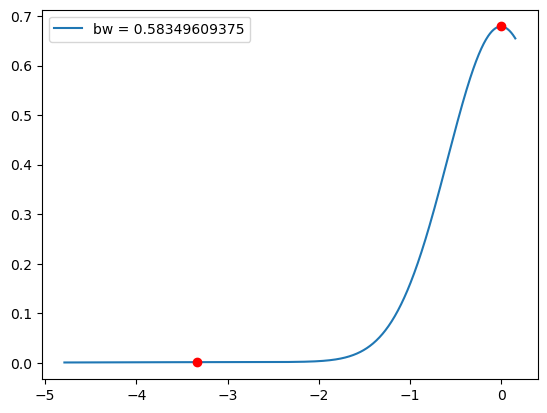

In [87]:
hcrit = hcritALL[0]
h = hcrit
print('hcrit', h)

y = np.array([KernelEstimator(i, data, h, GaussianKernel) for i in x])
local_max = argrelextrema(y, np.greater)
plt.plot(x, y, label='bw = '+str(h))
plt.plot([x[i] for i in local_max], [y[i] for i in local_max], 'ro')
plt.legend(loc='best')

for i in local_max[0]:
    print('x: ', x[i], ' | y: ', y[i]) 
            

x:  -3.335107743511986e+00  | y:  0.0014893499749138973
x:  -0.006310355871151252  | y:  0.6786374913693828


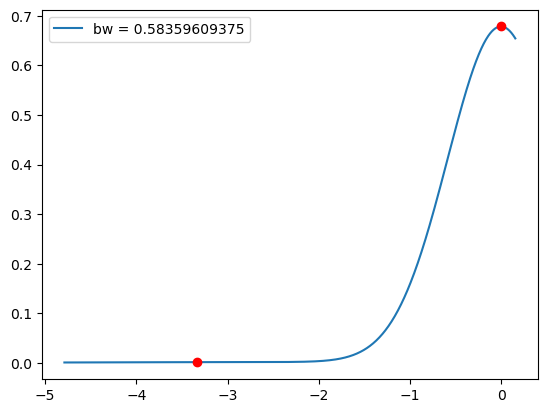

In [88]:
h = hcrit+0.0001
y = np.array([KernelEstimator(i, data, h, GaussianKernel) for i in x])
local_max = argrelextrema(y, np.greater)
plt.plot(x, y, label='bw = '+str(h))
plt.plot([x[i] for i in local_max], [y[i] for i in local_max], 'ro')
plt.legend(loc='best')

for i in local_max[0]:
    print('x: ', x[i], ' | y: ', y[i]) 

# Find the good h.

In [89]:
sizeData = len(data)
sig = np.std(data)
hcrit = hcritALL[1]

new_ind = np.random.randint(sizeData, size=sizeData) 
new_sample = np.array([data[i] for i in new_ind])

new_sam = new_sample + hcrit * norm.rvs(0,1, sizeData)
new_sam = new_sam / np.sqrt(1+hcrit**2 / sig**2)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


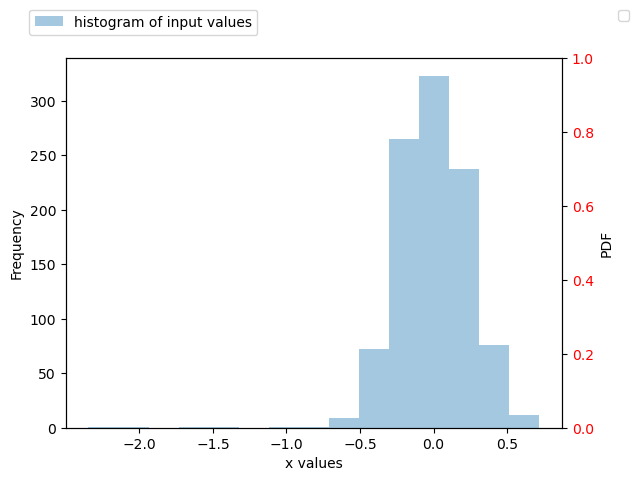

In [90]:
plotHistogramAndPdf(new_sam)

x:  -1.3641487572719768e-03  | y:  0.6786253529018305


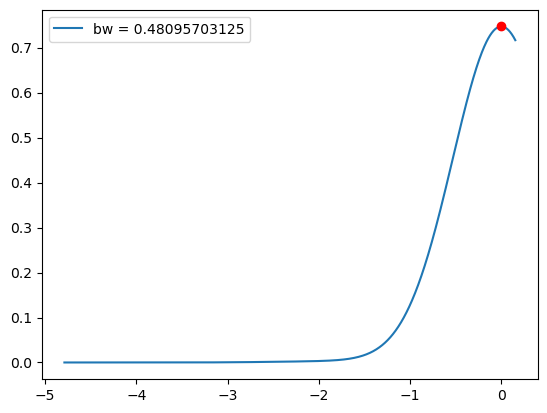

In [91]:
ybis = np.array([KernelEstimator(i, new_sam, hcrit, GaussianKernel) for i in x])
local_maxbis = argrelextrema(ybis, np.greater)
plt.plot(x, ybis, label='bw = '+str(hcrit))
plt.plot([x[i] for i in local_maxbis], [ybis[i] for i in local_maxbis], 'ro')
plt.legend(loc='best')

for i in local_maxbis[0]:
    print('x: ', x[i], ' | y: ', y[i]) 

# Iterative Methods

In [92]:
sizeData = len(data)
sig = np.std(data)
N = 50

for idx,hcrit in enumerate(hcritALL):
    num_ok = 0
    for iter in range(N):
        new_ind = np.random.randint(sizeData, size=sizeData) 
        new_sample = np.array([data[i] for i in new_ind])

        new_sam = new_sample + hcrit * norm.rvs(0,1, sizeData)
        new_sam = new_sam / np.sqrt(1+hcrit**2 / sig**2)

        ybis = np.array([KernelEstimator(i, new_sam, hcrit, GaussianKernel) for i in x])
        local_maxbis = argrelextrema(ybis, np.greater)
        if len(local_maxbis[0]) <= idx+1:
            num_ok = num_ok + 1
        
    print('Reject', idx+1,'mode | p-value', num_ok/N, ' | bw', hcrit)

Reject 1 mode | p-value 1.0  | bw 0.58349609375
Reject 2 mode | p-value 1.0  | bw 0.48095703125
Reject 3 mode | p-value 1.0  | bw 0.418701171875
Reject 4 mode | p-value 1.0  | bw 0.30303955078125


SyntaxError: invalid syntax (3341942528.py, line 1)